In [20]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization 
import matplotlib.pyplot as plt

import json
%matplotlib inline

In [9]:
def load_df(csv_path, nrows=None):
    json_columns = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(csv_path,
                     converters={column: json.loads for column in json_columns},
                     dtype={'fullVisitorId': 'str'},
                     nrows=nrows)
    
    for column in json_columns:
        column_df = pd.io.json.json_normalize(list(df[column].values))
        column_df.columns = [f'{column}.{sub_column}' for sub_column in column_df.columns]
        df = df.drop(column, axis=1).join(column_df)
        
    return df

In [12]:
# load and transform data
#train_df = load_df('train.csv')
train_df = load_df('train.csv')
test_df = load_df('test.csv')

In [11]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,NaN,google


the ratio of non zero revenue is:  0.0127427231470487
the ratio of non zero revenue for unique users is:  0.013996726255903731


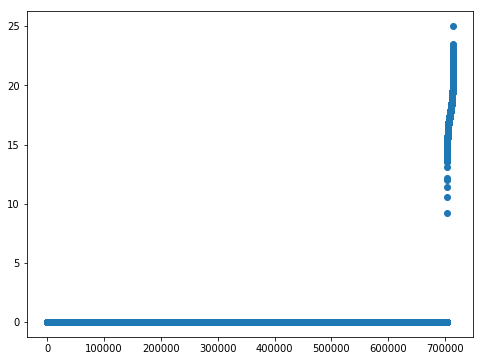

In [36]:
# target variable exploration
# convert target variables to float type
train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].fillna(0)
train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].astype(float)

# for every sample in training dataset
nonzero_ratio_train = sum(train_df['totals.transactionRevenue'] > 0) / train_df.shape[0]
print('the ratio of non zero revenue is: ', nonzero_ratio_train)

# for unique users in training dataset
revenue_sum = train_df.groupby(['fullVisitorId'])['totals.transactionRevenue'].sum().reset_index()
nonzero_ratio_unique_train = sum(revenue_sum['totals.transactionRevenue'] > 0) / revenue_sum.shape[0]
print('the ratio of non zero revenue for unique users is: ', nonzero_ratio_unique_train)

# plot revenue_sum
plt.figure(figsize=(8, 6))
plt.scatter(range(revenue_sum.shape[0]), np.sort(np.log1p(revenue_sum['totals.transactionRevenue'].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

In [49]:
# number of unique visitors in train and test dataset and common visitors belong to both two datsets
print('number of unique visitors in train is {} out of rows {}'.format(train_df['fullVisitorId'].nunique(), train_df.shape[0]))
print('number of unique visitors in test is {} out of rows {}'.format(test_df['fullVisitorId'].nunique(), test_df.shape[0]))
print('number of common visitors in train and test is {}'.format(len(set(train_df['fullVisitorId'].unique()).intersection(set(test_df['fullVisitorId'].unique())))))

number of unique visitors in train is 714167 out of rows 903653
number of unique visitors in test is 617242 out of rows 804684
number of common visitors in train and test is 7679


In [51]:
# search for the constant features
constant_features = [c for c in train_df.columns if train_df[c].nunique(dropna=False) == 1]

In [108]:
# drop constant features
train_df = train_df.drop(constant_features, axis=1)

In [109]:
# select categorical features
categorical_columns = [c for c in train_df.columns if train_df[c].dtype == 'O']
categorical_columns

['channelGrouping',
 'fullVisitorId',
 'sessionId',
 'device.browser',
 'device.deviceCategory',
 'device.operatingSystem',
 'geoNetwork.city',
 'geoNetwork.continent',
 'geoNetwork.country',
 'geoNetwork.metro',
 'geoNetwork.networkDomain',
 'geoNetwork.region',
 'geoNetwork.subContinent',
 'totals.bounces',
 'totals.hits',
 'totals.newVisits',
 'totals.pageviews',
 'trafficSource.adContent',
 'trafficSource.adwordsClickInfo.adNetworkType',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.adwordsClickInfo.page',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.campaign',
 'trafficSource.campaignCode',
 'trafficSource.isTrueDirect',
 'trafficSource.keyword',
 'trafficSource.medium',
 'trafficSource.referralPath',
 'trafficSource.source']

In [91]:
# device browser exploration
browser_plot_info = train_df.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'mean']).reset_index()

In [92]:
tmp = train_df[train_df['totals.transactionRevenue'] != 0]
tmp = tmp.groupby('device.browser')['totals.transactionRevenue'].count().reset_index()
browser_plot_info = browser_plot_info.merge(tmp, on='device.browser', how='left')
browser_plot_info = browser_plot_info.rename(columns={'size': 'count', 'totals.transactionRevenue': 'count_nonzero'})

In [93]:
# sort
browser_plot_info = browser_plot_info.sort_values('count', ascending=False)
browser_plot_info = browser_plot_info.reset_index(drop=True)

Text(0.5,1,'mean revenue')

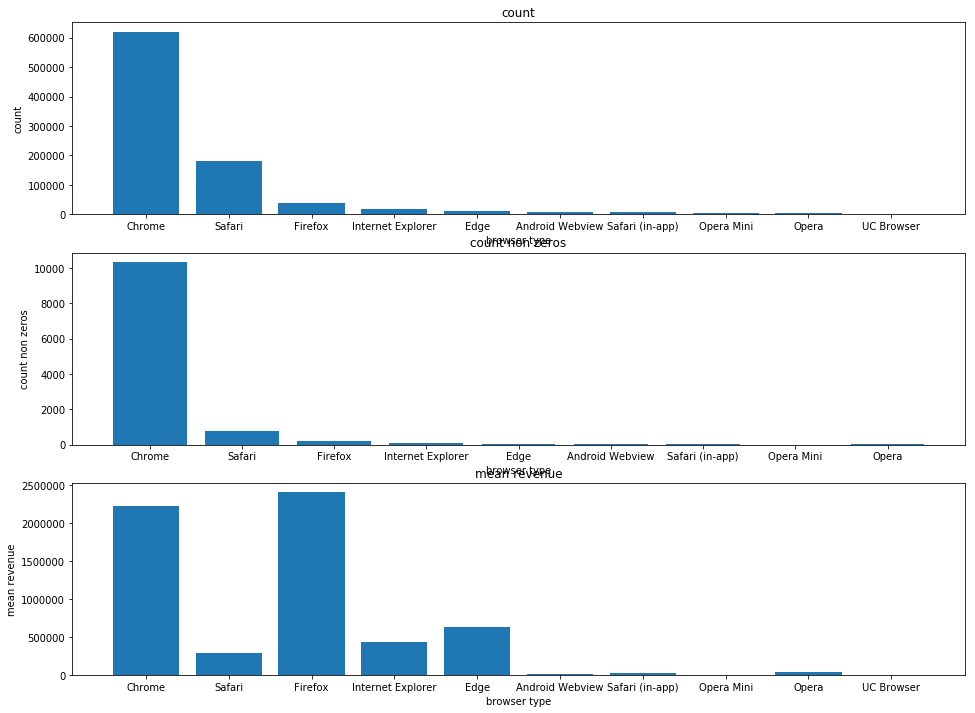

In [106]:
# histogram plot
browser_plot_info = browser_plot_info.head(10)
plt.figure(figsize=(16, 12))
plt.subplot(3, 1, 1)
plt.bar(browser_plot_info['device.browser'], browser_plot_info['count'])
plt.xlabel('browser type')
plt.ylabel('count')
plt.title('count')
plt.subplot(3, 1, 2)
plt.bar(browser_plot_info['device.browser'], browser_plot_info['count_nonzero'])
plt.xlabel('browser type')
plt.ylabel('count non zeros')
plt.title('count non zeros')
plt.subplot(3, 1, 3)
plt.bar(browser_plot_info['device.browser'], browser_plot_info['mean'])
plt.xlabel('browser type')
plt.ylabel('mean revenue')
plt.title('mean revenue')